## Model Selection

Here is a machine learning model.

**Model Selection** refers to the choice of:
- Which input features to include
- What preprocessing to do
- What ml method to use

**Hyperparamter Tuning** refer to the choice of parameters in the machine learning method.

For k-nearest neighbors, hyperparamters include:
- k
- metric (e.g., Euclidean distance)

The right wat to evaluate machine learning models is `test error`. Which is estimated using `cross-validation`.

- The distinction is not important. We always use cross-validation and pick the model / hyperparameter with the smallest test error.

In [2]:
import pandas as pd

df = pd.read_csv("https://dlsun.github.io/pods/data/bordeaux.csv", index_col="year")

df_train = df.loc[:1980].copy()
df_test = df.loc[1980:].copy()

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5, metric="euclidean")
)
X_train = df_train[["win", "summer"]]
y_train = df_train["price"]

In [5]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipeline,
    X=X_train, y=y_train,
    scoring="neg_mean_squared_error",
    cv=4
)

-scores.mean()

np.float64(375.27166666666665)

### Selecting features

For the the database we are using right now we can use:
- winter rain, summer temp
- winter rain, summer temp, harvest rain
- winter rain, summer temp, harvest rain, Sept. temp

In [10]:
for features in [["win", "summer"],
                 ["win", "summer", "har"],
                 ["win", "summer", "har", "sep"]]:
    scores = cross_val_score(
        pipeline,
        X=df_train[features],
        y=df_train["price"],
        scoring="neg_mean_squared_error",
        cv=4
    )
    print(features, -scores.mean())

['win', 'summer'] 375.27166666666665
['win', 'summer', 'har'] 363.04047619047617
['win', 'summer', 'har', 'sep'] 402.4507142857142


### Example of Hyperparamter Tuning: Finding best k for KNN

- if k is too small, the model becomes very sensitive to noies -> Overvitting
- if k is too large, the model becomes too smooth and loses detail -> Underfitting.
  

**Overfitting:** The model memorizes the training data instead of learning general patterns. So simply it learns too much.
- The training performance is very food, but test performance is bad. It fits noise and irrelevant details.

Causes usually include:
- Model too complex
- Too many features
- Not enough training data
- Not enough regularization

**Underfitting:** The model does not learn enough, It can not capture patterns in the data.
- The training performance is bad and test performance is also bad.

Causes usually include:
- Model too simple
- Not enough features
- Not enough training

<Axes: >

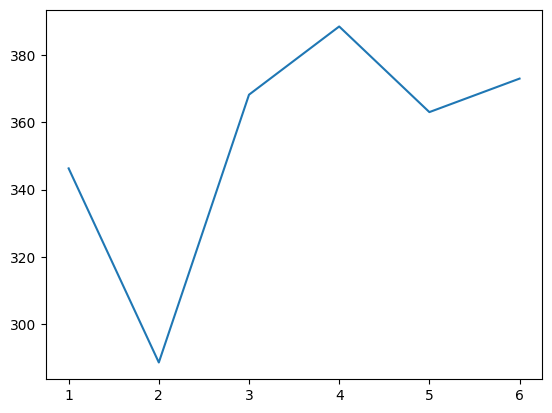

In [11]:
X_train = df_train[["win", "summer", "har"]]

ks, test_mses = range(1,7), []

for k in ks:
    pipeline = make_pipeline(
        StandardScaler(),
        KNeighborsRegressor(n_neighbors=k, metric="euclidean")
    )
    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring = "neg_mean_squared_error",
        cv=4
    )
    test_mses.append(-scores.mean())

pd.Series(test_mses, index=ks).plot.line()

The best value of k is 2.

## Grid Search

Suppose we want to choose k and the distance metric (Manhattan or Euclidean)

We need to try all 12 combinations on the following grid:

![grid](https://i.imgur.com/NVlxNH3.png)

Scikit-Learn's `GridSearchCV` automates the creation of a grid with all combinations.

In [12]:
pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5, metric="manhattan"))

In [13]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(
    pipeline,
    param_grid={
        "kneighborsregressor__n_neighbors": range(1, 7),
         "kneighborsregressor__metric": ["euclidean", "manhattan"],
    },
    scoring="neg_mean_squared_error", cv=4)

grid_cv.fit(X_train, y_train)
grid_cv.best_params_

{'kneighborsregressor__metric': 'euclidean',
 'kneighborsregressor__n_neighbors': 2}

Where did the parameter names in param_grid come from?

`pipeline.steps` gives a list of all the steps in the pipeline

In [15]:
pipeline.steps 

[('standardscaler', StandardScaler()),
 ('kneighborsregressor', KNeighborsRegressor(metric='manhattan'))]

### Challenges with Grid Search

- All maching learning can not be automated by grid search.

In the original data there were 5 input features we can generate 32 combinations of features with them.($2^5=32$)

If we combine this with the choice of k, distance metric, and scaler.

- 6 choices of k
- 2 choices of distance metric
- 2 choices of scaler

That makes $32 * 6 * 2 * 2 = 768$

### Heuristics for Parameter Tuning

For large data sets, it is impossible to try every combination of models and parameters.

So instead we use `heuristics`, which do not guarantee the best model but tend to work well in practice.

- **Randomized Search:** Try random combinations of parameters, implemented in Scikit-Learn as `RandomizedSearchCV`
- **Cooridinated Optimization:**
  - Start with guessing for all paramters,
  - Try all values for one parameter (holding the rest constant) and find the best value of that parameter.
  - Cycle through the parameters